# FD2425
Jorge Machado 21181


Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import tkinter as tk
from sklearn.model_selection import train_test_split
from sklearn import metrics
from lazypredict.Supervised import LazyRegressor
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, median_absolute_error,r2_score
from sklearn.decomposition import PCA


#Classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE

Primeiramente, neste projeto, foi utilizado o Lazy Predictor Regressor para identificar os melhores modelos de regressão para este tipo de desafio.

Para este teste, foram utilizadas todas as features do dataset. Posteriormente, após identificar os melhores modelos, foram testadas diferentes combinações de features.

Devido ao facto de o dataset ter 38 mil amostras e o Lazy Regressor utilizar 42 modelos, a execução completa seria computacionalmente pesada. Por isso, apenas metade das amostras foram utilizadas para este teste.

**Lazy Predictor Regressor**

In [ ]:
# Load the dataset with the specified columns
df = pd.read_csv('./cars.csv')

# Remove rows with NaN in any column
df = df.dropna().copy()

# Convert categorical variables to dummy variables
df = pd.get_dummies(df, drop_first=True)

# Sample the data (e.g., 10% of the original data)
df_sample = df.sample(frac=0.5, random_state=50)

# Split the data into features and target variable
X = df_sample.drop(['price_usd'], axis=1)
y = np.log1p(df_sample['price_usd'])  # Use log-transformed target for training

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize LazyRegressor
reg = LazyRegressor()

# Fit and evaluate models
models, predictions = reg.fit(X_train, X_test, y_train, y_test)

# Display all the evaluated models
print(models)

# Supervised Learning

Como estamos perante uma variável contínua, foi primeiramente utilizada a regressão.

## Inicialização do Dataset

Nesta primeira célula, foi aberto o dataset e lidas todas as colunas do mesmo. Este dataset conta com 30 colunas: `manufacturer_name`, `model_name`, `transmission`, `color`, `odometer_value`, `year_produced`, `engine_fuel`, `engine_has_gas`, `engine_type`, `engine_capacity`, `body_type`, `has_warranty`, `state`, `drivetrain`, `price_usd`, `is_exchangeable`, `location_region`, `number_of_photos`, `up_counter`, `feature_0`, `feature_1`, `feature_2`, `feature_3`, `feature_4`, `feature_5`, `feature_6`, `feature_7`, `feature_8`, `feature_9`, `duration_listed`, e com 38,521 amostras.

Posteriormente, foi percorrido o dataframe em busca de valores `NaN`. Caso alguma linha contivesse um `NaN`, essa mesma linha seria eliminada do dataset a ser utilizado.

In [2]:
# Load the dataset with the specified columns
df = pd.read_csv('./cars.csv')

# Remove rows with NaN in any column
df = df.dropna().copy()


print(df.describe(), "\n")
print(df.shape, "\n\n")
print (df.columns, "\n\n")
print(df.isnull().sum())


       odometer_value  year_produced  engine_capacity  price_usd  \
count        38521.00       38521.00         38521.00   38521.00   
mean        248910.07        2002.94             2.06    6637.16   
std         136059.50           8.06             0.67    6425.20   
min              0.00        1942.00             0.20       1.00   
25%         158000.00        1998.00             1.60    2100.00   
50%         250000.00        2003.00             2.00    4800.00   
75%         325000.00        2009.00             2.30    8950.00   
max        1000000.00        2019.00             8.00   50000.00   

       number_of_photos  up_counter  duration_listed  
count          38521.00    38521.00         38521.00  
mean               9.65       16.31            80.58  
std                6.09       43.29           112.84  
min                1.00        1.00             0.00  
25%                5.00        2.00            23.00  
50%                8.00        5.00            59.00  
75

**First Tests**

Nesta secção, é realizada a codificação das variáveis categóricas do conjunto de dados. Como os modelos de Machine Learning não conseguem trabalhar diretamente com dados categóricos, foram aplicadas duas técnicas de codificação:

1. **Label Encoding:**  
   Para colunas com um grande número de categorias únicas, foi utilizado o `LabelEncoder` da biblioteca `sklearn.preprocessing`. Este método converte os valores categóricos em números inteiros. Guardamos os codificadores num dicionário que pode ser revertida mais tarde, se necessário.

2. **One-Hot Encoding:**  
   Para as restantes variáveis categóricas, foi aplicado One-Hot Encoding com `pd.get_dummies()`. Esta técnica cria colunas binárias (0 ou 1) para representar cada categoria, evitando atribuir uma relação ordinal errada entre as classes.

Por fim, separamos os dados em:
- **Variáveis independentes (`X`)**: Todos os atributos, exceto a variável alvo (`price_usd`).
- **Variável dependente (`Y`)**: O preço do carro (`price_usd`), ao qual aplicamos a transformação `log1p` para suavizar a distribuição e melhorar o desempenho do modelo.

In [3]:
# Label encode columns with many unique values
label_encode_columns = ['manufacturer_name', 'model_name', 'transmission', 'color',
                                        'odometer_value', 'year_produced', 'engine_fuel', 'engine_has_gas', 
                                        'engine_type', 'engine_capacity', 'body_type', 'has_warranty', 
                                        'state', 'drivetrain',  'is_exchangeable', 'location_region','duration_listed','number_of_photos','up_counter']
label_encoders = {}


for col in label_encode_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# One-hot encode the remaining categorical variables
df = pd.get_dummies(df, columns=[col for col in df.columns if df[col].dtype == 'object' and col not in label_encode_columns], drop_first=True)

# Separate features and target variable
X = df.drop(['price_usd'], axis=1)
Y = np.log1p(df['price_usd'])  # target



Nesta secção, procede-se à divisão dos dados em conjuntos de treino e teste, ao treino de três modelos de regressão e à avaliação do seu desempenho com diferentes métricas.

Primeiramente, a divisão do conjunto de dados é realizada através da função `train_test_split()`, resultando em `X_train` e `Y_train` (conjunto de treino, correspondente a 80% dos dados) e `X_test` e `Y_test` (conjunto de teste, correspondente a 20% dos dados). O parâmetro `random_state` é definido como `1`, de forma a garantir a reprodutibilidade dos resultados.

Os modelos utilizados nesta análise foram selecionados com base nos três melhores desempenhos identificados pelo **LazyPredict Regressor**, uma ferramenta que permite testar múltiplos modelos de forma rápida e eficiente. Assim, foram escolhidos:

1. **LGBMRegressor (LightGBM):** Um modelo otimizado para elevada velocidade e eficiência em grandes volumes de dados.
2. **HistGradientBoostingRegressor:** Uma versão otimizada do algoritmo Gradient Boosting, disponível na biblioteca `sklearn`.
3. **GradientBoostingRegressor:** Um modelo tradicional de boosting aplicado a problemas de regressão.
Foi definida a função `calculate_metrics()`, responsável pelo cálculo das métricas utilizadas para avaliar o desempenho dos modelos:

- **R² (Coeficiente de Determinação):** Mede a qualidade do ajuste do modelo aos dados. Quanto mais próximo de 1, melhor.
- **MAE (Erro Absoluto Médio):** Calcula a média das diferenças absolutas entre os valores reais e previstos. Quanto mais próximo de 0, melhor.
- **MSE (Erro Quadrático Médio):** Penaliza erros mais significativos de forma mais acentuada do que o MAE. Quanto mais próximo de 0, melhor.
- **MAPE (Erro Percentual Absoluto Médio):** Mede o erro médio percentual, permitindo uma interpretação relativa da precisão do modelo. Quanto mais próximo de 0, melhor.

Uma vez que a variável alvo foi transformada através de `log1p()`, é necessário converter os valores de volta à escala original com `expm1()` antes do cálculo das métricas.

Para cada um dos modelos selecionados, procede-se às seguintes etapas:

- O treino do modelo é realizado com o método `.fit(X_train, Y_train)`.
- As previsões sobre o conjunto de teste são obtidas com `.predict(X_test)`.
- As métricas de avaliação são calculadas e os resultados são apresentados.

Através desta abordagem, torna-se possível comparar o desempenho dos diferentes modelos e selecionar aquele que melhor se adequa à previsão dos preços dos automóveis.


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)


# Function to calculate metrics
def calculate_metrics(y_test, y_pred):
    
    y_test_exp = np.expm1(y_test)  # Convert back from log scale
    y_pred_exp = np.expm1(y_pred)
    
    r2 = r2_score(y_test_exp, y_pred_exp)
    mae = metrics.mean_absolute_error(y_test_exp, y_pred_exp)
    mse = metrics.mean_squared_error(y_test_exp, y_pred_exp)
    mape = metrics.mean_absolute_percentage_error(y_test_exp, y_pred_exp)
    return r2, mae, mse,  mape

# Loop through different models
for i in range(1, 4):
    if i == 1:
        model = LGBMRegressor(verbose=-1)
        model_name = "LGBMRegressor"
    
    elif i == 2:
        model = HistGradientBoostingRegressor()
        model_name = "HistGradientBoostingRegressor"
    elif i == 3:
        model = GradientBoostingRegressor()
        model_name = "GradientBoostingRegressor"


    model.fit(X_train, Y_train)  # Train model

    # Predictions
    y_pred_test = model.predict(X_test) # Convert predictions back to original scale (if log-transformed)
   
    
    # Evaluate on test set
    r2_test, mae_test, mse_test, mape_test = calculate_metrics(Y_test, y_pred_test)

    # Resultados Teste
    print(f"\nResults for {model_name}:")
    print(f"Predicted Tests Price {y_pred_test}\n")
    print(f"R²: {r2_test:.4f}")
    print(f"MAE: {mae_test:.4f}")
    print(f"MSE: {mse_test:.4f}")
    print(f"MAPE: {mape_test:.4f}\n")


 
##### 1. Comparação do Desempenho dos Modelos

| Modelo                           | R²    | MAE     | MSE         | MAPE  |
|----------------------------------|-------|---------|------------|-------|
| LGBMRegressor                    | 0.9058 | 1124.13 | 3,961,863  | 0.7391 |
| HistGradientBoostingRegressor    | 0.9056 | 1122.02 | 3,973,558  | 0.6872 |
| GradientBoostingRegressor        | 0.8726 | 1303.63 | 5,362,874  | 0.6627 |

##### 2. Interpretação das Métricas

- **R²:** O LGBMRegressor apresentou o maior valor de R² (0.9058), seguido de perto pelo HistGradientBoostingRegressor (0.9056). O GradientBoostingRegressor teve um desempenho inferior (0.8726), indicando que explica menos variação da variável alvo comparado com os outros modelos.
- **MAE:** O HistGradientBoostingRegressor apresentou o menor MAE (1122.02), indicando que, em média, os erros de previsão são ligeiramente menores do que os do LGBMRegressor (1124.13). O GradientBoostingRegressor apresentou um MAE significativamente maior (1303.63), o que significa que, em média, as suas previsões estão mais distantes dos valores reais.
- **MSE:** O LGBMRegressor apresentou o menor MSE (3,961,863), indicando que penaliza erros elevados menos do que os outros modelos. O GradientBoostingRegressor teve um MSE superior (5,362,874), o que confirma que as suas previsões contêm maiores desvios em relação aos valores reais.
- **MAPE:** O GradientBoostingRegressor apresentou o menor MAPE (0.6627), sugerindo um desempenho relativamente estável em termos de erro percentual. O HistGradientBoostingRegressor e o LGBMRegressor apresentaram MAPE superiores (0.6872 e 0.7391, respetivamente), o que pode indicar que, em algumas faixas de preços, os erros relativos são mais elevados.

##### 3. Conclusão e Escolha do Melhor Modelo

- Tanto o LGBMRegressor como o HistGradientBoostingRegressor demonstraram desempenhos muito semelhantes, apresentando os melhores valores de R² e os menores erros absolutos.
- O GradientBoostingRegressor teve um desempenho inferior em todas as métricas, pelo que não é a melhor escolha para este problema.
- A decisão entre o LGBMRegressor e o HistGradientBoostingRegressor pode depender de outros fatores, como o tempo de treino e inferência, a escalabilidade e a interpretabilidade do modelo.

Dado o ligeiro melhor desempenho do LGBMRegressor em termos de R² e MSE, este poderá ser a melhor opção para prever os preços dos automóveis. No entanto, se o foco for o menor erro absoluto médio (MAE), o HistGradientBoostingRegressor pode ser preferível.


##### Segundo Testes - Regressão

Nesta secção, procede-se a uma segunda abordagem para a codificação das variáveis categóricas, utilizando um subconjunto diferente de features em relação ao método previamente apresentado.

Primeiramente, é aplicado `LabelEncoder()` às colunas com um elevado número de categorias únicas. No entanto, a lista de variáveis codificadas foi reduzida, incluindo apenas: `manufacturer_name`, `model_name`, `transmission`, `color`, `odometer_value`, `engine_fuel`, `engine_type`, `engine_capacity`, `body_type` e `state`. Cada coluna é transformada em valores numéricos inteiros, armazenando os codificadores num dicionário (`label_encoders_2`) para referência futura.

As variáveis categóricas não incluídas no `LabelEncoder` são submetidas a One-Hot Encoding através de `pd.get_dummies()`, permitindo uma melhor representação dos atributos sem impor relações ordinais artificiais.

Nesta abordagem, a matriz de features (`X_2`) é composta apenas pelas variáveis que foram submetidas a Label Encoding, em contraste com a abordagem anterior, que incluía um conjunto mais alargado de variáveis. A variável alvo (`Y_2`) continua a ser `price_usd`, à qual é aplicada a transformação `log1p()` para estabilizar a distribuição dos valores.

A principal diferença entre este método e o anteriormente apresentado reside na seleção das variáveis preditoras. Enquanto o primeiro código incluía todas as features numéricas e categóricas processadas, esta versão restringe `X_2` apenas às colunas submetidas a Label Encoding, potencialmente reduzindo a dimensionalidade do modelo. Esta abordagem pode ter impacto no desempenho preditivo, dependendo da relevância das variáveis excluídas.


In [6]:
# Label encode columns with many unique values
label_encode_columns_2 = [ 'manufacturer_name', 'model_name', 'transmission', 'color', 'odometer_value',  'engine_fuel','engine_type', 'engine_capacity', 'body_type', 'state']
label_encoders_2 = {}


for col in label_encode_columns_2:
    le_2 = LabelEncoder()
    df[col] = le_2.fit_transform(df[col])
    label_encoders_2[col] = le_2
    

# One-hot encode the remaining categorical variables
df_2 = pd.get_dummies(df, columns=[col for col in df.columns if df[col].dtype == 'object' and col not in label_encode_columns_2], drop_first=True)

# Separate features and target variable
X_2 = df_2[label_encode_columns_2]
Y_2 = np.log1p(df_2['price_usd'])  # target

In [ ]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, Y_2, test_size=0.2, random_state=42)


def calculate_metrics(y_test_2_in, y_pred_2_in):
       
       y_test_exp_2 = np.expm1(y_test_2_in)  # Convert back from log scale
       y_pred_exp_2 = np.expm1(y_pred_2_in)
       
       r2 = r2_score(y_test_exp_2, y_pred_exp_2)
       mae = metrics.mean_absolute_error(y_test_exp_2, y_pred_exp_2)
       mse = metrics.mean_squared_error(y_test_exp_2, y_pred_exp_2)
       mape = metrics.mean_absolute_percentage_error(y_test_exp_2, y_pred_exp_2)
       return r2, mae, mse,  mape


for i in range(1, 4):
    if i == 1:
        model = LGBMRegressor()
        model_name = "LGBMRegressor"
    elif i == 2:
        model = HistGradientBoostingRegressor()
        model_name = "HistGradientBoostingRegressor"
    elif i == 3:
        model = GradientBoostingRegressor()
        model_name = "GradientBoostingRegressor" 


    model.fit(X_train_2, y_train_2)
    
    y_pred_2 = model.predict(X_test_2) # Convert predictions back to USD
    r2, mae, mse, mape = calculate_metrics(y_test_2, y_pred_2)
    
    # Print results
    print(f"\nResultado do {model_name}")
    print(f"R²: {model.score(X_test_2, y_test_2):.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"MAPE: {mape:.4f}")
   


#### 1. **Resumo das Métricas**  

| Modelo                           | R²    | MAE     | MSE         | MAPE  |
|----------------------------------|-------|---------|------------|-------|
| **LGBMRegressor**                | 0.7485 | 2032.73 | 11,295,135 | 0.5900 |
| **HistGradientBoostingRegressor** | 0.7430 | 2048.73 | 11,366,388 | 0.5839 |
| **GradientBoostingRegressor**     | 0.6550 | 2437.42 | 15,360,181 | 0.7226 |

#### 2. **Interpretação das Métricas**  

- **Coeficiente de Determinação (R²):**  
  - O **LGBMRegressor** apresentou o melhor R² (**0.7485**), indicando que explica aproximadamente **74.85%** da variabilidade do preço dos automóveis.  
  - O **HistGradientBoostingRegressor** obteve um valor semelhante (**0.7430**), sugerindo um desempenho próximo ao do LGBM.  
  - O **GradientBoostingRegressor** obteve um R² significativamente inferior (**0.6550**), o que indica que explica menos variação da variável dependente e pode gerar previsões menos precisas.  

- **Erro Absoluto Médio (MAE):**  
  - O **LGBMRegressor** apresentou o menor MAE (**2032.73**), sugerindo que, em média, as suas previsões apresentam um erro absoluto menor.  
  - O **HistGradientBoostingRegressor** registou um MAE ligeiramente superior (**2048.73**), o que demonstra um desempenho muito semelhante ao do LGBM.  
  - O **GradientBoostingRegressor** teve o MAE mais elevado (**2437.42**), indicando que os seus erros médios são maiores.  

- **Erro Quadrático Médio (MSE):**  
  - O **LGBMRegressor** registou o menor MSE (**11,295,135**), seguido pelo **HistGradientBoostingRegressor** (**11,366,388**), demonstrando um desempenho quase idêntico entre os dois modelos.  
  - O **GradientBoostingRegressor** obteve um MSE muito superior (**15,360,181**), sugerindo previsões menos precisas e mais sujeitas a desvios elevados.  

- **Erro Percentual Absoluto Médio (MAPE):**  
  - O **HistGradientBoostingRegressor** apresentou o menor MAPE (**0.5839**), o que significa que, em média, os erros relativos deste modelo são ligeiramente menores do que os do **LGBMRegressor** (**0.5900**).  
  - O **GradientBoostingRegressor** registou um MAPE substancialmente superior (**0.7226**), indicando maior instabilidade nas previsões.  

#### 3. **Conclusão e Escolha do Melhor Modelo**  
Os resultados indicam que **LGBMRegressor** e **HistGradientBoostingRegressor** apresentam desempenhos muito próximos, superando o **GradientBoostingRegressor** em todas as métricas.  

- Se o critério principal for o **menor erro absoluto (MAE)** e o **melhor ajuste geral (R²)**, o **LGBMRegressor** é a melhor escolha.  
- Se a prioridade for a **redução do erro percentual médio (MAPE)**, o **HistGradientBoostingRegressor** pode ser ligeiramente mais adequado.  
- O **GradientBoostingRegressor** apresentou um desempenho inferior em todas as métricas e, portanto, não é a melhor opção para este problema.  

Dado que o **LGBMRegressor** obteve o melhor equilíbrio entre **precisão e erro absoluto**, este modelo pode ser considerado a melhor escolha para prever os preços dos automóveis.  


**Thrid Test** 

Neste caso, foi realizada a codificação das variáveis categóricas que apresentam muitos valores únicos utilizando **Label Encoding**. As colunas selecionadas para esta codificação foram:  

- **'manufacturer_name'**
- **'model_name'**
- **'transmission'**
- **'color'**
- **'odometer_value'**
- **'year_produced'**

Essas colunas foram codificadas em valores numéricos, permitindo que o modelo processe essas variáveis de maneira eficiente. Após a codificação, as variáveis categóricas restantes que não estavam na lista de codificação foram convertidas utilizando **One-Hot Encoding**.

As **features** utilizadas neste conjunto de dados são:  
- **'manufacturer_name'**
- **'model_name'**
- **'transmission'**
- **'color'**
- **'odometer_value'**
- **'year_produced'**

A variável alvo (**target**) é o preço do veículo (**'price_usd'**), que foi transformado usando **log1p** para normalizar sua distribuição e melhorar o desempenho do modelo.  

A separação das **features** e **target** resultou nas variáveis **X_3** (features) e **Y_3** (target).


In [8]:
# Label encode columns with many unique values
label_encode_columns_3 = ['manufacturer_name', 'model_name', 'transmission', 'color', 'odometer_value', 'year_produced']
label_encoders_3 = {}


for col_3 in label_encode_columns_3:
    le_3 = LabelEncoder()
    df[col_3] = le_3.fit_transform(df[col_3])
    label_encoders_3[col_3] = le_3

# One-hot encode the remaining categorical variables
df_3 = pd.get_dummies(df, columns=[col_3 for col_3 in df.columns if df[col_3].dtype == 'object' and col_3 not in label_encode_columns_3], drop_first=True)

# Separate features and target variable
X_3 = df_3[label_encode_columns_3]
Y_3 = np.log1p(df_3['price_usd'])  # target

In [ ]:
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X_3, Y_3, test_size=0.2, random_state=42)



def calculate_metrics(y_test_3_in, y_pred_3_in):
    
    y_test_exp_3 = np.expm1(y_test_3_in)  # Convert back from log scale
    y_pred_exp_3 = np.expm1(y_pred_3_in)
    
    r2 = metrics.r2_score(y_test_exp_3, y_pred_exp_3)
    mae = metrics.mean_absolute_error(y_test_exp_3, y_pred_exp_3)
    mse = metrics.mean_squared_error(y_test_exp_3, y_pred_exp_3)
    mape = metrics.mean_absolute_percentage_error(y_test_exp_3, y_pred_exp_3)
    return r2, mae, mse, mape


for i in range(1, 4):
    if i == 1:
        model = LGBMRegressor()
        model_name = "LGBMRegressor"
    elif i == 2:
        model = HistGradientBoostingRegressor()
        model_name = "HistGradientBoostingRegressor"
    elif i == 3:
        model = GradientBoostingRegressor()
        model_name = "GradientBoostingRegressor" 


    model.fit(X_train_3, y_train_3)
    
    y_pred_3 = model.predict(X_test_3) # Convert predictions back to USD
    
    r2, mae, mse, mape = calculate_metrics(y_test_3, y_pred_3)
    
    # Print results
    print(f"\nResultado do {model_name}")
    print(f"R²: {model.score(X_test_3, y_test_3):.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"MAPE: {mape:.4f}")


| Modelo                           | R²    | MAE     | MSE         | MAPE  |
|----------------------------------|-------|---------|------------|-------|
| **LGBMRegressor**                | 0.8623 | 1330.29 | 6,030,781  | 0.5712 |
| **HistGradientBoostingRegressor** | 0.8611 | 1337.73 | 6,089,253  | 0.5817 |
| **GradientBoostingRegressor**     | 0.8172 | 1738.28 | 9,759,197  | 0.6160 |

##### 2. **Interpretação das Métricas**  

- **Coeficiente de Determinação (R²):**  
  - O **LGBMRegressor** apresentou o melhor R² (**0.8623**), indicando que explica aproximadamente **86.23%** da variabilidade do preço dos automóveis.  
  - O **HistGradientBoostingRegressor** obteve um valor semelhante (**0.8611**), com uma ligeira diferença em relação ao LGBM.  
  - O **GradientBoostingRegressor** apresentou um desempenho inferior (**0.8172**), explicando **81.72%** da variabilidade dos preços.  

- **Erro Absoluto Médio (MAE):**  
  - O **LGBMRegressor** obteve o menor MAE (**1330.29**), o que indica que, em média, suas previsões estão mais próximas dos valores reais.  
  - O **HistGradientBoostingRegressor** teve um MAE ligeiramente superior (**1337.73**), mas a diferença é pequena e pode ser considerada negligível.  
  - O **GradientBoostingRegressor** teve o MAE mais alto (**1738.28**), sugerindo que as suas previsões, em média, têm um erro absoluto maior.  

- **Erro Quadrático Médio (MSE):**  
  - O **LGBMRegressor** apresentou o menor MSE (**6,030,781**), indicando previsões com menores desvios quadráticos em comparação com os outros modelos.  
  - O **HistGradientBoostingRegressor** teve um MSE ligeiramente superior (**6,089,253**), o que demonstra um desempenho muito semelhante ao LGBM.  
  - O **GradientBoostingRegressor** teve um MSE muito mais alto (**9,759,197**), o que indica que as suas previsões estão mais distantes dos valores reais, principalmente em termos quadráticos.  

- **Erro Percentual Absoluto Médio (MAPE):**  
  - O **LGBMRegressor** apresentou o menor MAPE (**0.5712**), o que indica que seus erros percentuais médios são mais baixos do que os dos outros modelos.  
  - O **HistGradientBoostingRegressor** obteve um MAPE ligeiramente superior (**0.5817**), mas ainda muito próximo do LGBM.  
  - O **GradientBoostingRegressor** obteve o MAPE mais alto (**0.6160**), o que sugere maior instabilidade nas suas previsões.  

##### 3. **Conclusão e Escolha do Melhor Modelo**  
Os resultados indicam que tanto o **LGBMRegressor** quanto o **HistGradientBoostingRegressor** superaram o **GradientBoostingRegressor** em todas as métricas.  

- Se o critério principal for **menor erro absoluto (MAE)** e **melhor ajuste geral (R²)**, o **LGBMRegressor** é a melhor opção.  
- Se a prioridade for **menor erro percentual (MAPE)**, o **LGBMRegressor** também se destaca, embora a diferença para o **HistGradientBoostingRegressor** seja pequena.  
- O **GradientBoostingRegressor** apresentou um desempenho inferior em todas as métricas e, portanto, não é a melhor escolha para este problema.  

Dado o **excelente equilíbrio entre precisão e erro absoluto** do **LGBMRegressor**, este modelo pode ser considerado a melhor escolha para prever os preços dos automóveis.


**Fourth Tests**
 -PCA

A Análise de Componentes Principais (PCA) é uma técnica fundamental para a redução de dimensionalidade dos dados, especialmente útil quando lidamos com conjuntos de dados com muitas variáveis. Em problemas de regressão, como o que estamos tratando aqui, o PCA pode ser muito vantajoso para melhorar a performance do modelo, tornar o treinamento mais rápido e reduzir o risco de overfitting.

A principal razão para usar o PCA é que ele permite reduzir o número de features (variáveis) no conjunto de dados, mantendo as informações mais relevantes. Isso é especialmente importante quando temos muitas variáveis que podem ser altamente correlacionadas entre si. O PCA transforma as variáveis originais em novas variáveis chamadas componentes principais, que são não correlacionadas e preservam a maior parte da variância dos dados. Ao fazer isso, o modelo se torna mais simples e, muitas vezes, mais preciso, pois elimina redundâncias e relações complexas entre as variáveis.

Outra vantagem do PCA é que ele ajuda a eliminar problemas de multicolinearidade, que podem ocorrer quando as variáveis explicativas estão fortemente correlacionadas. Isso é um problema para muitos modelos de regressão, pois pode levar a estimativas imprecisas. O PCA resolve isso criando componentes principais ortogonais (ou seja, sem correlação), o que facilita a modelagem e melhora a precisão das previsões.

Além disso, a redução da dimensionalidade proporcionada pelo PCA melhora a eficiência computacional. Com menos variáveis para processar, o modelo treina mais rápido, o que é particularmente útil quando lidamos com grandes volumes de dados. Essa redução de dimensionalidade também reduz o risco de overfitting, pois o modelo acaba focando nas características mais importantes dos dados, sem aprender padrões espúrios.

No código, o PCA é aplicado após a divisão dos dados em conjuntos de treino e teste. O número de componentes principais pode ser definido de diferentes maneiras: podemos escolher uma proporção de variância explicada, como 95% (o que significa que queremos preservar 95% da variação dos dados), ou definir um número fixo de componentes (como 10, 20 ou 3). A flexibilidade na escolha de n_components permite experimentar e encontrar o melhor equilíbrio entre a redução de dimensionalidade e a preservação de informações importantes.

No geral, o PCA é uma técnica poderosa que simplifica os dados e ajuda a melhorar o desempenho dos modelos de regressão. Ele torna os modelos mais rápidos, mais eficientes e menos propensos a overfitting, ao mesmo tempo em que mantém a maior parte da variabilidade e das informações dos dados originais.

In [7]:


X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


# Ensure the same columns are present in the training and testing sets
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

# Function to apply PCA and train the regressor model
def apply_pca_and_train_regressor(X_train, X_test, y_train, y_test, n_components):
    # Ensure n_components is within the valid range
    
    max_components = min(X_train.shape[0], X_train.shape[1])
    if isinstance(n_components, int) and n_components > max_components:
        n_components = max_components
    elif isinstance(n_components, float) and (n_components <= 0 or n_components > 1):
        raise ValueError("n_components must be between 0 and 1 for float values.")
    
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    
    
    
    for i in range(1, 4):
        if i == 1:
            model = LGBMRegressor()
            model_name = "LGBMRegressor"
        elif i == 2:
            model = HistGradientBoostingRegressor()
            model_name = "HistGradientBoostingRegressor"
        elif i == 3:
            model = GradientBoostingRegressor()
            model_name = "GradientBoostingRegressor" 
        
        
        
        model.fit(X_train_pca, y_train)
    

        y_pred = model.predict(X_test_pca)
        print ("PCA utilizing ", model_name)
        print(f"Results for PCA with {n_components} components:")
        print(f"R-Squared: {metrics.r2_score(y_test, y_pred):.2f}")
        print(f"RMSE: {metrics.mean_squared_error(y_test, y_pred, squared=False):.2f}")
        print(f"Mean_Absolute_Percentage_Error: {metrics.mean_absolute_percentage_error(y_test, y_pred):.2f}")
        print(f"Mean_Absolute_Error: {metrics.mean_absolute_error(y_test, y_pred):.2f}")
        print("____________________________________________\n")
                
# Apply PCA with different components and train the model
apply_pca_and_train_regressor(X_train, X_test, y_train, y_test, n_components=0.95)
apply_pca_and_train_regressor(X_train, X_test, y_train, y_test, n_components=10)
apply_pca_and_train_regressor(X_train, X_test, y_train, y_test, n_components=20)
apply_pca_and_train_regressor(X_train, X_test, y_train, y_test, n_components=3)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000233 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 30816, number of used features: 1
[LightGBM] [Info] Start training from score 8.349716
PCA utilizing  LGBMRegressor
Results for PCA with 0.95 components:
R-Squared: 0.27
RMSE: 0.88
Mean_Absolute_Percentage_Error: 0.09
Mean_Absolute_Error: 0.68
____________________________________________

PCA utilizing  HistGradientBoostingRegressor
Results for PCA with 0.95 components:
R-Squared: 0.26
RMSE: 0.89
Mean_Absolute_Percentage_Error: 0.09
Mean_Absolute_Error: 0.68
____________________________________________

PCA utilizing  GradientBoostingRegressor
Results for PCA with 0.95 components:
R-Squared: 0.27
RMSE: 0.88
Mean_Absolute_Percentage_Error: 0.09
Mean_Absolute_Error: 0.68
_____


**Resultados dos Testes**

**PCA com 0.95 Componentes**
- **Desempenho**: Relativamente baixo em todos os modelos.
- **R²**: Em torno de 0.27 a 0.26.
- **RMSE**: Elevado, em torno de 0.88 a 0.89.
- **MAE**: Em torno de 0.68.

**PCA com 10 Componentes**
- **Desempenho**: Melhoria significativa, especialmente com LGBMRegressor e HistGradientBoostingRegressor.
- **R²**: Subiu para valores em torno de 0.86.
- **RMSE**: Reduzido para cerca de 0.39.
- **MAE**: Reduzido para cerca de 0.27.

**PCA com 20 Componentes**
- **Desempenho**: Manteve um bom desempenho, especialmente com HistGradientBoostingRegressor.
- **R²**: Mais alto, com 0.87.
- **RMSE**: 0.38.
- **MAE**: Em torno de 0.26.

**PCA com 3 Componentes**
- **Desempenho**: Inferior.
- **R²**: Em torno de 0.45.
- **RMSE**: 0.76 a 0.77.

**Conclusão**
A redução de dimensionalidade através do PCA com 10 e 20 componentes trouxe melhorias no desempenho dos modelos, especialmente nos erros de previsão. O modelo HistGradientBoostingRegressor se destacou em termos de R² e RMSE. Isso sugere que a seleção de um número adequado de componentes principais é crucial para otimizar o desempenho dos modelos de regressão.

# Classification

Primeiramente, à semelhança na regressão, o dataset cars.csv é carregado utilizando a função pd.read_csv() do pandas, que lê o conteúdo do dataset CSV e armazena os dados em um DataFrame chamado df_classification. Este DataFrame contém as informações sobre os carros, e a função head() é utilizada logo em seguida para exibir as primeiras linhas do conjunto de dados, proporcionando uma visão rápida dos dados e suas primeiras entradas.

Em seguida, o código dropna() é aplicado para remover quaisquer linhas do DataFrame que contenham valores ausentes (NaN). Isso é feito para garantir que o modelo não enfrente problemas ao tentar treinar com dados incompletos. O copy() é usado para criar uma cópia independente do DataFrame após a remoção dos valores ausentes, assegurando que o DataFrame original não seja alterado acidentalmente. O resultado dessa operação é um novo DataFrame limpo, sem dados ausentes, pronto para ser utilizado no modelo de classificação.

In [8]:
df_classification=pd.read_csv('./cars.csv')
df_classification.head()
df_classification.dropna().copy()

,manufacturer_name,model_name,transmission,color,odometer_value,year_produced,engine_fuel,engine_has_gas,engine_type,engine_capacity,...,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,duration_listed
0,Subaru,Outback,automatic,silver,190000,2010,gasoline,False,gasoline,2.50,...,True,True,True,False,True,False,True,True,True,16
1,Subaru,Outback,automatic,blue,290000,2002,gasoline,False,gasoline,3.00,...,True,False,False,True,True,False,False,False,True,83
2,Subaru,Forester,automatic,red,402000,2001,gasoline,False,gasoline,2.50,...,True,False,False,False,False,False,False,True,True,151
3,Subaru,Impreza,mechanical,blue,10000,1999,gasoline,False,gasoline,3.00,...,False,False,False,False,False,False,False,False,False,86
4,Subaru,Legacy,automatic,black,280000,2001,gasoline,False,gasoline,2.50,...,True,False,True,True,False,False,False,False,True,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38526,Chrysler,300,automatic,silver,290000,2000,gasoline,False,gasoline,3.50,...,True,False,False,True,True,False,False,True,True,301
38527,Chrysler,PT Cruiser,mechanical,blue,321000,2004,diesel,False,diesel,2.20,...,True,False,False,True,True,False,False,True,True,317
38528,Chrysler,300,automatic,blue,777957,2000,gasoline,False,gasoline,3.50,...,True,False,False,True,True,False,False,True,True,369
38529,Chrysler,PT Cruiser,mechanical,black,20000,2001,gasoline,False,gasoline,2.00,...,True,False,False,False,False,False,False,False,True,490


histograma de todos os preços

Neste trecho de código, é feita uma categorização dos preços dos carros, agrupando-os em faixas de preço definidas pelos bins (intervalos). Essas faixas são atribuídas à coluna price_category do DataFrame df_classification.

Depois, a distribuição das categorias de preço é visualizada com o uso de um countplot do Seaborn, que mostra quantos carros existem em cada faixa de preço definida. O gráfico resultante ajuda a entender como os carros estão distribuídos entre as diferentes categorias de preço, proporcionando uma visão clara da concentração de preços dentro de cada intervalo.

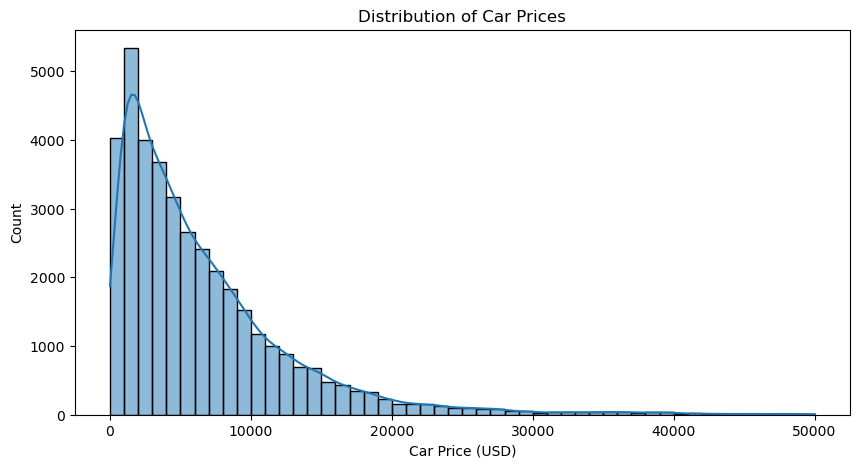

In [9]:
# Visualize the distribution of prices
plt.figure(figsize=(10, 5))
sns.histplot(df_classification['price_usd'], bins=50, kde=True)
plt.xlabel("Car Price (USD)")
plt.ylabel("Count")
plt.title("Distribution of Car Prices")
plt.show()


Neste código, é criada uma segmentação dos preços dos carros em diferentes categorias, usando intervalos específicos (bins) para agrupar os dados. As faixas de preço são definidas com base nos valores de price_bins, que determinam os limites para as categorias de preços. Cada intervalo é rotulado usando a lista price_labels, que atribui um nome a cada faixa de preço.

A seguir, a função pd.cut() é utilizada para atribuir essas categorias de preço a cada linha do DataFrame, criando uma nova coluna price_category. Isso permite classificar cada carro em uma das categorias de preço predefinidas, com base no valor da coluna price_usd.

O código também exibe a distribuição das categorias de preço com o comando value_counts(), que retorna a contagem de carros em cada faixa de preço, oferecendo uma visão geral da quantidade de carros em cada categoria.

Finalmente, a distribuição das categorias é visualizada em um gráfico de barras, gerado pelo countplot do Seaborn. Esse gráfico ajuda a identificar como os carros estão distribuídos entre as diferentes faixas de preço, fornecendo uma representação visual clara da quantidade de carros em cada categoria.


Price Categories Distribution:
price_category
1-5k       19784
5k-10k     10697
10k-20k     6442
20k-30k     1120
30k-40k      360
40k-50k      126
Name: count, dtype: int64


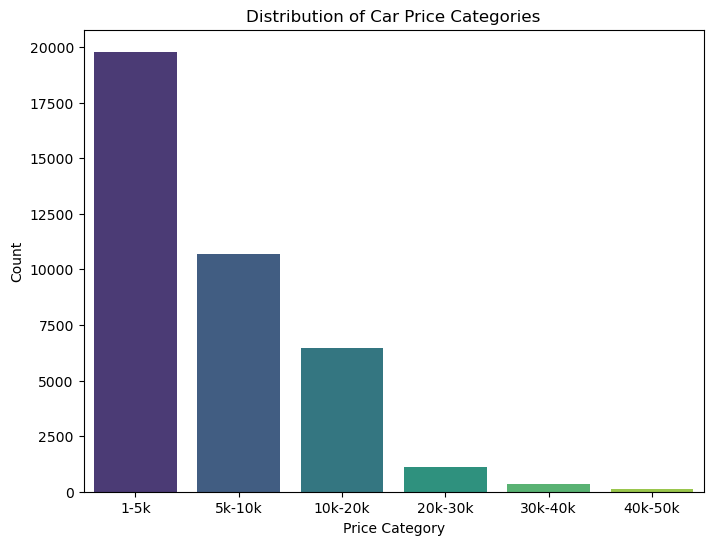

In [10]:
# Define bins and labels for price categories, starting from 1 dollar
price_bins = [1, 4999, 9999, 19999, 29999, 39999, 50000]
price_labels = ['1-5k', '5k-10k', '10k-20k', '20k-30k', '30k-40k', '40k-50k']

# Assign the labels to the 'price_usd' column, starting from 1 dollar
df_classification['price_category'] = pd.cut(df_classification['price_usd'], bins=price_bins, labels=price_labels, right=False)

# Show the distribution of the new target variable
print("\nPrice Categories Distribution:")
print(df_classification['price_category'].value_counts())

# Plot the distribution of price categories
plt.figure(figsize=(8, 6))
sns.countplot(x='price_category', data=df_classification, palette='viridis')
plt.title("Distribution of Car Price Categories")
plt.xlabel("Price Category")
plt.ylabel("Count")
plt.show()

O objetivo principal é preparar os dados para que possam ser utilizados em modelos de machine learning, aplicando técnicas de codificação para lidar com variáveis categóricas.

Primeiramente, a função fillna(method='ffill') é utilizada para preencher valores ausentes no DataFrame df_classification. O método 'ffill' preenche os valores ausentes com o valor da linha anterior, garantindo que não haja dados faltando ao longo do processo de treinamento.

Em seguida, o código usa a técnica de Label Encoding para converter as variáveis categóricas em números. A lista label_encode_columns contém as colunas com muitas variáveis únicas, que serão codificadas. O LabelEncoder() é aplicado a cada uma dessas colunas, transformando os valores em números inteiros, e os codificadores são armazenados no dicionário label_encoders. Essa técnica permite que o modelo de machine learning trabalhe com esses dados de forma numérica, já que a maioria dos algoritmos de aprendizado de máquina não consegue lidar diretamente com dados categóricos.

Após o Label Encoding, o código aplica o One-Hot Encoding para as outras variáveis categóricas restantes (que não estão na lista label_encode_columns). O One-Hot Encoding cria colunas binárias (0 ou 1) para cada categoria, permitindo que o modelo reconheça cada categoria como uma variável distinta. Isso é feito usando pd.get_dummies(), que cria essas novas colunas e descarta a primeira de cada conjunto para evitar a multicolinearidade, conforme indicado pelo parâmetro drop_first=True.

Esse processo de codificação garante que todas as variáveis categóricas estejam prontas para serem usadas em modelos de machine learning.

In [11]:
# Label encode columns with many unique values
label_encode_columns = ['manufacturer_name', 'model_name', 'transmission', 'color',
                                        'odometer_value', 'year_produced', 'engine_fuel', 'engine_has_gas', 
                                        'engine_type', 'engine_capacity', 'body_type', 'has_warranty', 
                                        'state', 'drivetrain',  'is_exchangeable', 'location_region','duration_listed','number_of_photos','up_counter']
label_encoders = {}
df_classification.fillna(method='ffill', inplace=True)

for col in label_encode_columns:
    le = LabelEncoder()
    df_classification[col] = le.fit_transform(df_classification[col])
    label_encoders[col] = le

# One-hot encode the remaining categorical variables
df_classification = pd.get_dummies(df_classification, columns=[col for col in df_classification.columns if df_classification[col].dtype == 'object' and col not in label_encode_columns], drop_first=True)



De seguida é feita a preparação dos dados para os modelos de classificação, onde a variável alvo será a categoria de preço (`price_category`), em vez do valor contínuo do preço dos carros.

Primeiro, são separadas as features (variáveis independentes) e a variável alvo. A variável alvo `Y` é a coluna `price_category`, que contém as categorias de preço em que os carros foram classificados. Já as features (`X`) são todas as colunas do DataFrame, exceto `price_usd` e `price_category`, pois o preço contínuo (`price_usd`) e a categoria de preço (`price_category`) não devem ser usadas como features para prever a variável alvo.

Em seguida, o código utiliza a função `train_test_split` para dividir o conjunto de dados em dois subconjuntos: treino e teste. O parâmetro `test_size=0.2` indica que 20% dos dados serão usados para testes, enquanto os 80% restantes serão usados para treino. O parâmetro `random_state=1` garante que a divisão dos dados seja reprodutível, ou seja, ao executar o código novamente, a divisão dos dados será a mesma.

Com isso, os dados estão prontos para serem usados num modelo de classificação, onde a variável alvo é a categoria de preço dos carros.

In [12]:
# Now, you can use 'price_category' as your target for classification
# Separate features and target variable
X = df_classification.drop(['price_usd', 'price_category'], axis=1)  # Drop price_usd and the new target
Y = df_classification['price_category']  # Target is the new categorical price category

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)


São avaliados três modelos de classificação para prever a categoria de preço dos carros. Os modelos escolhidos são:

- **Random Forest (RandomForestClassifier)**, com a opção `class_weight='balanced'` para lidar com desequilíbrios nas classes.
- **Linear SVC (LinearSVC)**, também com `class_weight='balanced'`.
- **K-Nearest Neighbors (KNeighborsClassifier)**, que é um modelo baseado na proximidade entre as observações.

A avaliação de cada modelo segue os seguintes passos:

1. **Treinamento do modelo**: O método `fit()` é utilizado para treinar o modelo com os dados de treino (`X_train` e `Y_train`).

2. **Previsões**: Após o treino, o método `predict()` faz as previsões sobre o conjunto de teste (`X_test`), e os resultados são armazenados em `y_pred`.

3. **Relatório de Classificação**: Para cada modelo, o `classification_report()` é impresso, fornecendo métricas como precisão (precision), recall, F1-score e suporte (support) para cada categoria de preço.

4. **Matriz de Confusão**: A `confusion_matrix()` é utilizada para mostrar quantas observações de cada categoria de preço foram classificadas corretamente e incorretamente. Esta matriz é uma boa ferramenta para ver se o modelo tem dificuldades em distinguir entre algumas classes. A matriz de confusão é exibida visualmente usando um heatmap com a biblioteca Seaborn. O heatmap mostra os valores das previsões para cada classe (categoria de preço) nas linhas e as classes reais nas colunas.

5. **Visualização**: O gráfico gerado pela `sns.heatmap()` exibe a matriz de confusão de forma visual, ajudando a identificar rapidamente quais classes o modelo tem mais dificuldade em distinguir. O título, os rótulos das variáveis e a legenda são configurados para melhorar a leitura.

Este processo é repetido para os três modelos, permitindo comparar o desempenho de cada um em termos de métricas de classificação e a capacidade de discriminar entre as diferentes categorias de preço.


Evaluating Model: Random Forest

Random Forest Classification Report:
              precision    recall  f1-score   support

        1-5k       0.93      0.94      0.93      4003
     10k-20k       0.73      0.79      0.76      1258
     20k-30k       0.56      0.26      0.36       247
     30k-40k       0.65      0.27      0.38        64
     40k-50k       0.67      0.18      0.29        22
      5k-10k       0.77      0.79      0.78      2113

    accuracy                           0.84      7707
   macro avg       0.72      0.54      0.58      7707
weighted avg       0.84      0.84      0.84      7707


Random Forest Confusion Matrix:
[[3751    3    0    0    0  249]
 [  14  992   15    0    0  237]
 [   2  174   65    3    1    2]
 [   0   18   28   17    1    0]
 [   0    3    9    6    4    0]
 [ 278  164    0    0    0 1671]]


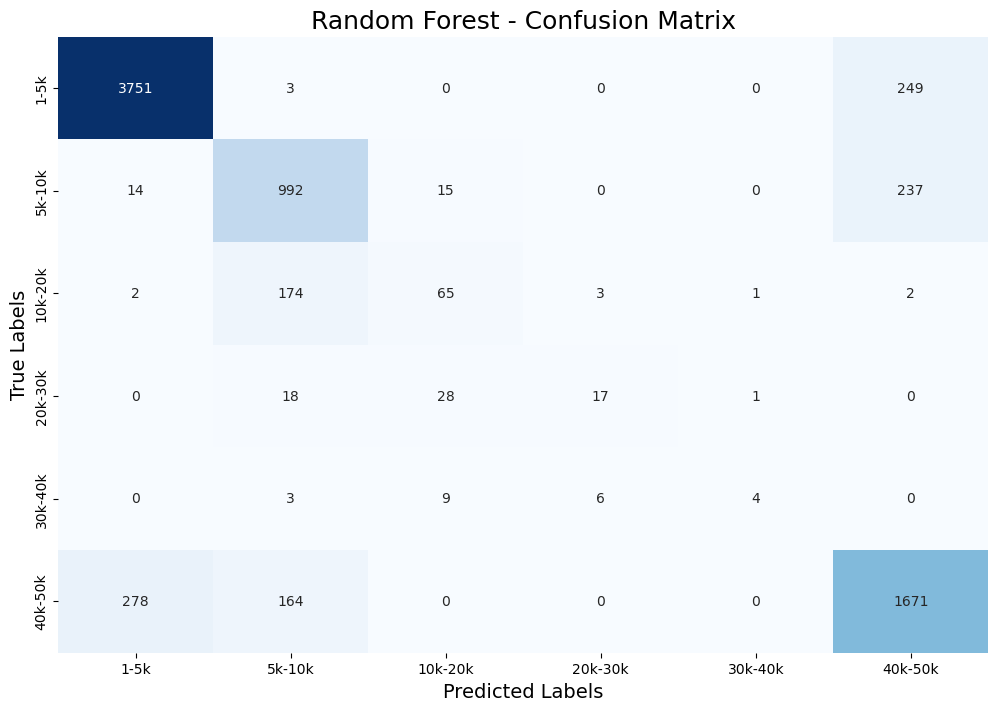


Evaluating Model: Linear SVC

Linear SVC Classification Report:
              precision    recall  f1-score   support

        1-5k       0.85      0.91      0.88      4003
     10k-20k       0.49      0.65      0.56      1258
     20k-30k       0.27      0.34      0.30       247
     30k-40k       0.20      0.28      0.23        64
     40k-50k       0.26      0.50      0.34        22
      5k-10k       0.65      0.42      0.51      2113

    accuracy                           0.71      7707
   macro avg       0.45      0.52      0.47      7707
weighted avg       0.71      0.71      0.70      7707


Linear SVC Confusion Matrix:
[[3625   93    5    0    0  280]
 [  50  813  162   41    5  187]
 [   3  111   85   23   16    9]
 [   0   16   19   18   11    0]
 [   0    3    4    3   11    1]
 [ 566  616   43    5    0  883]]


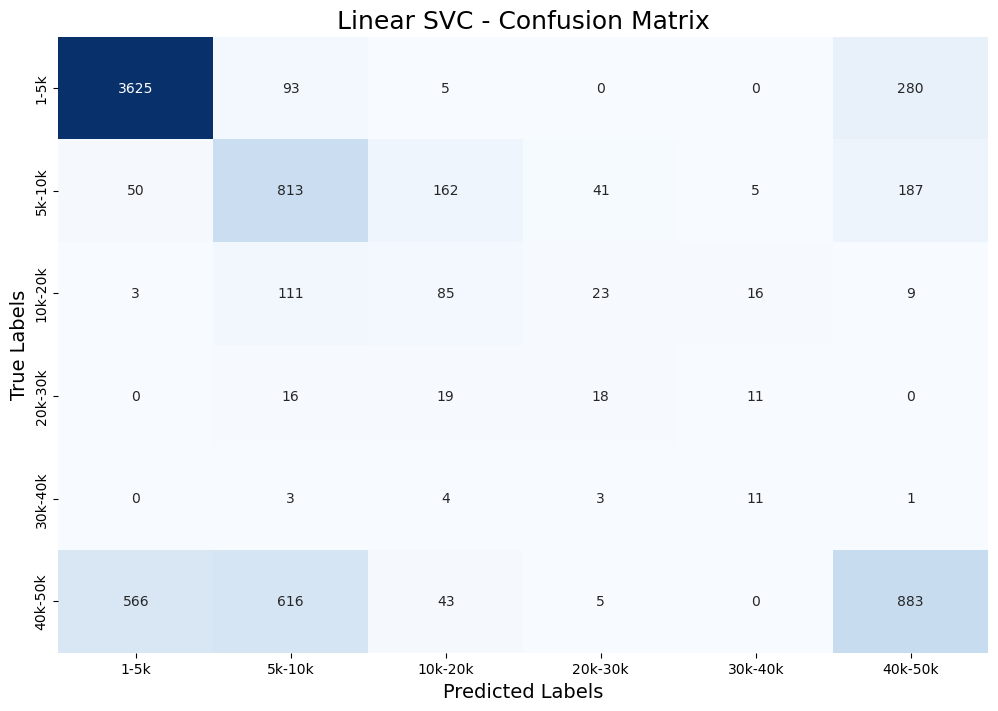


Evaluating Model: KNeighbors

KNeighbors Classification Report:
              precision    recall  f1-score   support

        1-5k       0.69      0.84      0.76      4003
     10k-20k       0.42      0.42      0.42      1258
     20k-30k       0.30      0.09      0.14       247
     30k-40k       0.50      0.14      0.22        64
     40k-50k       0.00      0.00      0.00        22
      5k-10k       0.42      0.31      0.36      2113

    accuracy                           0.59      7707
   macro avg       0.39      0.30      0.32      7707
weighted avg       0.56      0.59      0.57      7707


KNeighbors Confusion Matrix:
[[3347  173    5    1    0  477]
 [ 361  528   23    2    0  344]
 [  42  132   23    3    1   46]
 [  10   32    6    9    0    7]
 [   7    6    5    1    0    3]
 [1069  380   14    2    1  647]]


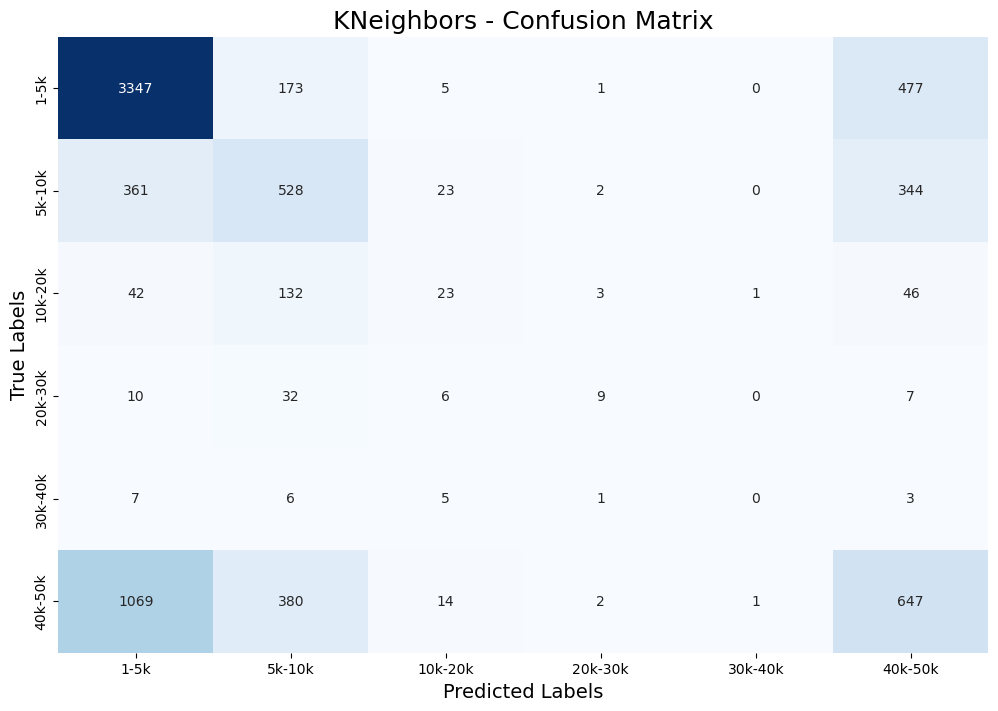

In [13]:

models = {
    'Random Forest': RandomForestClassifier(class_weight='balanced', random_state=1),
    'Linear SVC': LinearSVC(class_weight='balanced', random_state=1),
    'KNeighbors': KNeighborsClassifier()
}

# Loop through models, train, predict and output results
for model_name, model in models.items():
    print(f"\nEvaluating Model: {model_name}")
    
    # Train the model
    model.fit(X_train, Y_train)
    
    # Make predictions on the test set
    y_pred = model.predict(X_test)
    
    # Classification report
    print(f"\n{model_name} Classification Report:")
    print(classification_report(Y_test, y_pred))
    
    # Confusion matrix
    cm = confusion_matrix(Y_test, y_pred)
    print(f"\n{model_name} Confusion Matrix:")
    print(cm)
    
    # Plotting the confusion matrix
    plt.figure(figsize=(12, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['1-5k', '5k-10k', '10k-20k', '20k-30k', '30k-40k', '40k-50k'], yticklabels=['1-5k', '5k-10k', '10k-20k', '20k-30k', '30k-40k', '40k-50k'], cbar=False)

    
    # Title and labels
    plt.title(f'{model_name} - Confusion Matrix', fontsize=18)
    plt.xlabel('Predicted Labels', fontsize=14)
    plt.ylabel('True Labels', fontsize=14)
    plt.show()






Teste 2

Feita a categorização dos preços dos carros em três faixas específicas, ao invés de seis, como no exemplo anterior. O objetivo é criar uma variável categórica que agrupe os carros de acordo com o seu preço, facilitando a classificação em categorias mais amplas.

As faixas de preço foram definidas da seguinte forma:

- **1-10k:** Para carros com preços entre 1 e 9.999 USD.
- **10k-30k:** Para carros com preços entre 10.000 e 29.999 USD.
- **30k-50k:** Para carros com preços entre 30.000 e 49.999 USD.

A função `pd.cut()` é utilizada para categorizar os valores da coluna `price_usd` com base nesses intervalos definidos. O parâmetro `right=False` garante que o valor final de cada intervalo não seja incluído na faixa, ou seja, um carro com preço exato de 10.000 USD será colocado na categoria 10k-30k.

Após categorizar os preços, a distribuição das novas categorias é exibida com `value_counts()`, o que permite verificar quantos carros pertencem a cada faixa de preço. Em seguida, é gerado um gráfico de barras, utilizando `sns.countplot()`, para visualizar a distribuição das categorias de preços. O gráfico tem o título "Distribuição das Categorias de Preço dos Carros", e os eixos são rotulados para identificar as faixas de preço e a contagem de carros em cada uma delas.

Essa abordagem de classificação por intervalos de preço simplifica a tarefa de modelagem, transformando o problema de regressão em um problema de classificação, onde o modelo deve prever a faixa de preço a que o carro pertence.



Price Categories Distribution:
price_category
1-10k      30481
10k-30k     7562
30k-50k      486
Name: count, dtype: int64


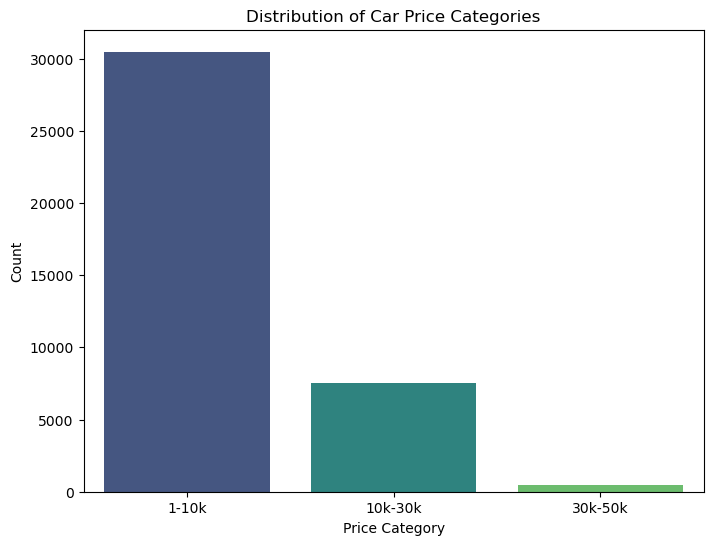

In [14]:
# Define bins and labels for price categories, starting from 1 dollar
price_bins = [1,  9999, 29999, 50000]
price_labels = ['1-10k', '10k-30k', '30k-50k']

# Assign the labels to the 'price_usd' column, starting from 1 dollar
df_classification['price_category'] = pd.cut(df_classification['price_usd'], bins=price_bins, labels=price_labels, right=False)

# Show the distribution of the new target variable
print("\nPrice Categories Distribution:")
print(df_classification['price_category'].value_counts())

# Plot the distribution of price categories
plt.figure(figsize=(8, 6))
sns.countplot(x='price_category', data=df_classification, palette='viridis')
plt.title("Distribution of Car Price Categories")
plt.xlabel("Price Category")
plt.ylabel("Count")
plt.show()

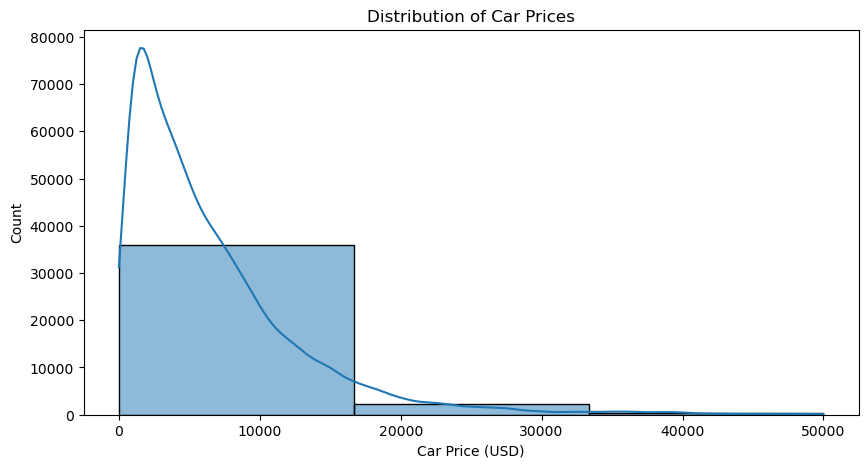

In [15]:
# Visualize the distribution of prices
plt.figure(figsize=(10, 5))
sns.histplot(df_classification['price_usd'], bins=3, kde=True)
plt.xlabel("Car Price (USD)")
plt.ylabel("Count")
plt.title("Distribution of Car Prices")
plt.show()


In [16]:
# Ensure df_classification is pre-processed and 'price_category' exists as a categorical target
df_classification.fillna(method='ffill', inplace=True)

# Label encode columns with many unique values
label_encode_columns = ['manufacturer_name', 'model_name', 'transmission', 'color',
                        'odometer_value', 'year_produced', 'engine_fuel', 'engine_has_gas',
                        'engine_type', 'engine_capacity', 'body_type', 'has_warranty',
                        'state', 'drivetrain', 'is_exchangeable', 'location_region', 
                        'duration_listed', 'number_of_photos', 'up_counter']

label_encoders = {}

for col in label_encode_columns:
    le = LabelEncoder()
    df_classification[col] = le.fit_transform(df_classification[col])
    label_encoders[col] = le


In [17]:
# One-hot encode the remaining categorical variables
df_classification = pd.get_dummies(df_classification, columns=[col for col in df_classification.columns 
                                                              if df_classification[col].dtype == 'object' and col not in label_encode_columns], drop_first=True)

# Separate features and target variable
X = df_classification.drop(['price_usd', 'price_category'], axis=1)  # Drop price_usd and the new target
Y = df_classification['price_category']  # Target is the new categorical price category

# Split the dataset into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

Aqui foi aplicada uma técnica chamada SMOTE (Synthetic Minority Over-sampling Technique) para lidar com o desequilíbrio nas classes de treino. Quando as classes de um problema de classificação possuem uma distribuição desigual (ou seja, algumas classes têm muito mais exemplos do que outras), os modelos podem ter dificuldades em aprender a prever as classes menos representadas. O SMOTE é uma abordagem eficaz para resolver esse problema.

O SMOTE cria novos exemplos sintéticos da classe minoritária, gerando instâncias adicionais para as classes menos representadas, com base nas características das instâncias existentes. Isso é feito interpolando entre os exemplos da classe minoritária. No código fornecido, os parâmetros são definidos da seguinte forma:

- `sampling_strategy='auto'`: Faz com que o SMOTE gere exemplos suficientes para equilibrar a distribuição das classes de forma automática. Ou seja, ele irá balancear o número de instâncias entre as classes minoritária e majoritária, até que ambas tenham o mesmo número de exemplos.
- `random_state=1`: Garante que a divisão dos dados e a geração dos exemplos sintéticos seja reprodutível, ou seja, sempre que o código for executado com este parâmetro, os resultados serão os mesmos.

O código `X_train_resampled, Y_train_resampled = smote.fit_resample(X_train, Y_train)` realiza o processo de balanceamento, aplicando o SMOTE ao conjunto de treino. Após a aplicação, as variáveis `X_train_resampled` e `Y_train_resampled` contêm as versões balanceadas das features e do target, prontas para serem usadas no treino do modelo.

Essa técnica ajuda a melhorar a performance do modelo em dados desbalanceados, garantindo que o modelo tenha mais chances de aprender adequadamente a prever as classes menos representadas.

In [18]:

smote = SMOTE(sampling_strategy='auto', random_state=1)
X_train_resampled, Y_train_resampled = smote.fit_resample(X_train, Y_train)


Evaluating Model: Random Forest

Random Forest Classification Report:
              precision    recall  f1-score   support

       1-10k       0.97      0.95      0.96      6116
     10k-30k       0.78      0.87      0.82      1505
     30k-50k       0.68      0.55      0.61        86

    accuracy                           0.93      7707
   macro avg       0.81      0.79      0.80      7707
weighted avg       0.93      0.93      0.93      7707


Random Forest Confusion Matrix:
[[5790  326    0]
 [ 177 1306   22]
 [   0   39   47]]


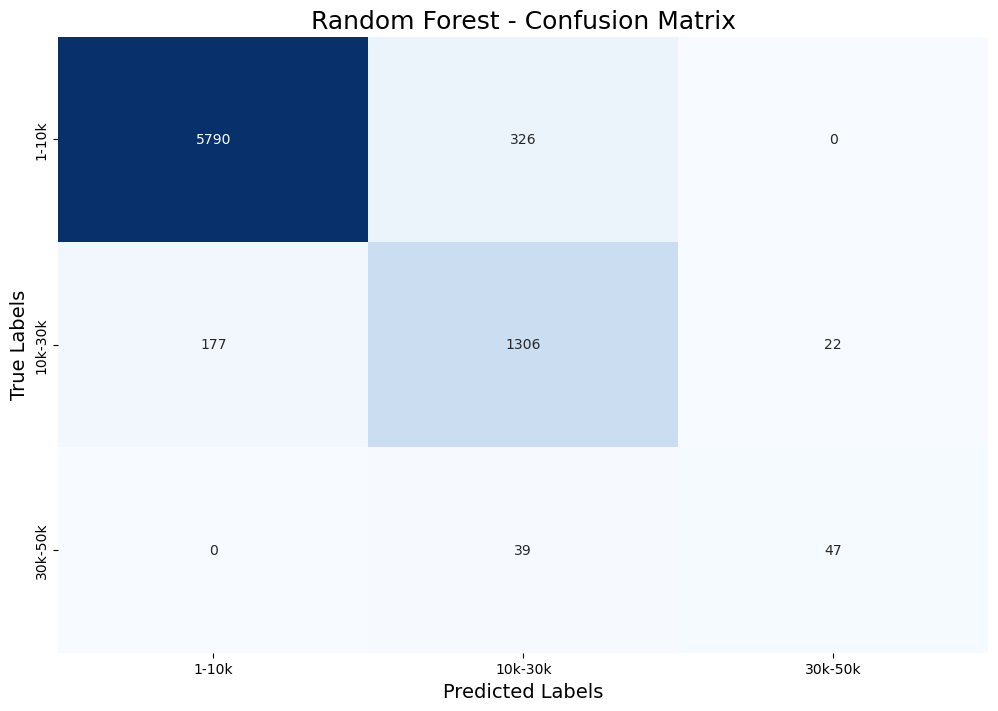


Evaluating Model: Linear SVC

Linear SVC Classification Report:
              precision    recall  f1-score   support

       1-10k       0.94      0.90      0.92      6116
     10k-30k       0.58      0.55      0.56      1505
     30k-50k       0.17      0.85      0.28        86

    accuracy                           0.83      7707
   macro avg       0.56      0.76      0.59      7707
weighted avg       0.86      0.83      0.84      7707


Linear SVC Confusion Matrix:
[[5504  574   38]
 [ 360  822  323]
 [   1   12   73]]


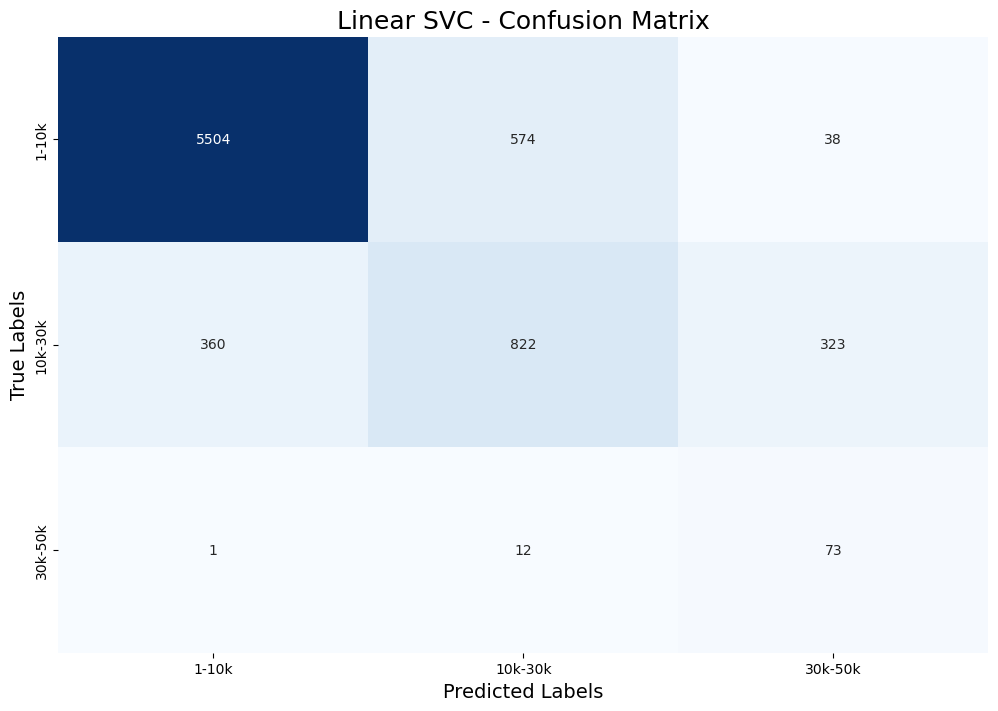


Evaluating Model: KNeighbors

KNeighbors Classification Report:
              precision    recall  f1-score   support

       1-10k       0.92      0.77      0.84      6116
     10k-30k       0.41      0.63      0.50      1505
     30k-50k       0.10      0.38      0.16        86

    accuracy                           0.73      7707
   macro avg       0.48      0.59      0.50      7707
weighted avg       0.81      0.73      0.76      7707


KNeighbors Confusion Matrix:
[[4684 1289  143]
 [ 412  947  146]
 [   7   46   33]]


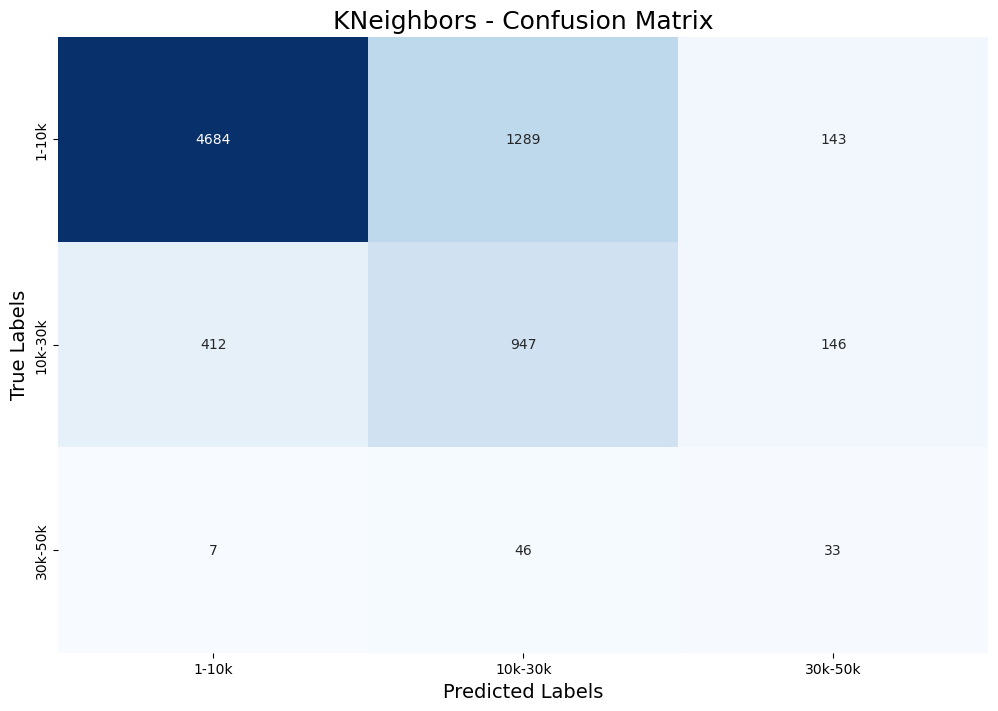

In [19]:
# Define models to use
models = {
    'Random Forest': RandomForestClassifier(class_weight='balanced', random_state=1),
    'Linear SVC': LinearSVC(class_weight='balanced', random_state=1),
    'KNeighbors': KNeighborsClassifier()
}

# Loop through models, train, predict and output results
for model_name, model in models.items():
    print(f"\nEvaluating Model: {model_name}")
    
    # Train the model
    model.fit(X_train_resampled, Y_train_resampled)
    
    # Make predictions on the test set
    y_pred = model.predict(X_test)
    
    # Classification report
    print(f"\n{model_name} Classification Report:")
    print(classification_report(Y_test, y_pred))
    
    # Confusion matrix
    cm = confusion_matrix(Y_test, y_pred)
    print(f"\n{model_name} Confusion Matrix:")
    print(cm)
    
    # Plotting the confusion matrix
    plt.figure(figsize=(12, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['1-10k', '10k-30k', '30k-50k'], 
                yticklabels=['1-10k', '10k-30k', '30k-50k'], cbar=False)
    
    # Title and labels
    plt.title(f'{model_name} - Confusion Matrix', fontsize=18)
    plt.xlabel('Predicted Labels', fontsize=14)
    plt.ylabel('True Labels', fontsize=14)
    plt.show()
